Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)
DOING BASELINE MODEL TRAINING

0 2.2943389415740967
100 1.9927153587341309
200 1.5725548267364502
300 1.7248287200927734
400 1.450641393661499
500 1.660408854484558
600 1.4007322788238525
700 1.318026065826416
800 1.1432029008865356
900 1.4927810430526733
1000 1.1255476474761963
1100 1.166626214981079
1200 1.309675931930542
1300 1.1326342821121216
1400 1.1851266622543335
1500 1.131097435951233
1600 0.9448041319847107
1700 0.9662469029426575
1800 1.1431208848953247
1900 0.8689776062965393
2000 0.9107990264892578
2100 1.1936208009719849
2200 0.8444869518280029
2300 0.8775249123573303
2400 0.8503451347351074
2500 0.6863454580307007
2600 0.9301682710647583
2700 0.6476162075996399
2800 0.852841317653656
2900 0.727329432964325
3000 0.6264047026634216
3100 0.8870484828948975
3200 0.5628611445426941
3300 0.6710310578346252
3400 0.5623313784599304
3500 0.5270071029663086
3600 0.6932

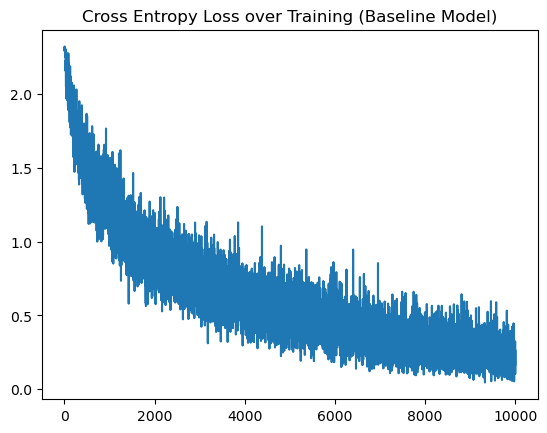

Testing Set Cross Entropy Loss (Baseline Model): 1.0052971839904785
Testing Set Accuracy (Baseline Model): 0.7491000294685364
Training Set Cross Entropy Loss (Baseline Model): 0.20523808896541595
Training Set Accuracy (Baseline Model): 0.9302200078964233
TRAINING TIME: 7911.213276863098 seconds
TEST TIME: 127.91747188568115 seconds


In [3]:
import torch
import torchvision
import cifar10
import torchvision.datasets as D
import numpy as np
import torch.nn as nn
import matplotlib
from matplotlib import pyplot as plt
import time
import Models
from Models import Conv2dBlock, CNNClassifier
import utils
from utils import load_data

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = load_data(DEVICE)

ITERATIONS = 10000
BATCH_SIZE = 64
PRINT_EVERY = 100
OUT_CLASSES = 10
        

layers = [Conv2dBlock([3,32,32]), Conv2dBlock([32,64,64]), Conv2dBlock([64,128,128]), 
          nn.Flatten(), nn.Linear(2048,128), nn.ReLU(), nn.Linear(128,OUT_CLASSES)]
        
MODEL = CNNClassifier(layers, 1e-3, nn.functional.cross_entropy).to(DEVICE)

print("DOING BASELINE MODEL TRAINING")
print()

losses = []
train_start = time.time()

for itr in range(ITERATIONS+1):
    idxs = np.random.randint(0,50000, size = (BATCH_SIZE,))
        
    X, Y = X_TRAIN[idxs], Y_TRAIN[idxs]
    
    loss = MODEL.backprop(X,Y)
    if itr%PRINT_EVERY == 0:
        print(itr,loss)
    losses.append(loss)

train_time = time.time() - train_start
        
plt.clf()
plt.plot(np.arange(len(losses)), np.array(losses))
plt.title("Cross Entropy Loss over Training (Baseline Model)")
plt.show()
plt.clf()

test_start = time.time()
loss = MODEL.compute_loss(X_TEST, Y_TEST)
acc = MODEL.compute_accuracy(X_TEST, Y_TEST)
test_time = time.time() - test_start

print("Testing Set Cross Entropy Loss (Baseline Model):", loss)
print("Testing Set Accuracy (Baseline Model):", acc)

loss = MODEL.compute_loss(X_TRAIN, Y_TRAIN)
acc = MODEL.compute_accuracy(X_TRAIN, Y_TRAIN)

print("Training Set Cross Entropy Loss (Baseline Model):", loss)
print("Training Set Accuracy (Baseline Model):", acc)

print("TRAINING TIME:", train_time, "seconds")
print("TEST TIME:",test_time, "seconds")

In [1]:
import torch
import torchvision
import cifar10
import torchvision.datasets as D
import numpy as np
import torch.nn as nn
from torch.nn.parameter import Parameter
import matplotlib
from matplotlib import pyplot as plt
import time
import Models
from Models import Conv2dBlock, CNNClassifier, RankConv2d, RankConv2dBlock
import utils
from utils import load_data, safe_mkdir, get_paths
import os
        
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def run_exp_rank(DATA, DEVICE, kernels_size, ranks, seed = 42, ITERATIONS = 10000, BATCH_SIZE = 64, verbose = False, PRINT_EVERY = 100, OUT_CLASSES = 10):
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = DATA
    parpath, folderpath = get_paths(kernels_size, ranks, seed)
    safe_mkdir(parpath)
    safe_mkdir(folderpath)
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    layers = [RankConv2dBlock([3,32,32], [ranks,ranks], (kernels_size, kernels_size)), 
              RankConv2dBlock([32,64,64], [ranks,ranks], (kernels_size, kernels_size)), 
              RankConv2dBlock([64,128,128], [ranks,ranks], (kernels_size, kernels_size)), 
              nn.Flatten(), nn.Linear(2048,128), nn.ReLU(), nn.Linear(128,OUT_CLASSES)]
    MODEL = CNNClassifier(layers, 1e-3, nn.functional.cross_entropy).to(DEVICE)
    MODEL.train()

    print("DOING MODEL TRAINING, RANK: " + str(ranks) + ", KERNEL SIZE: " + str(kernels_size) + ", SEED: " + str(seed))
    print()
    
    losses = []
    train_start = time.time()

    for itr in range(ITERATIONS+1):
        idxs = np.random.randint(0,50000, size = (BATCH_SIZE,))

        X, Y = X_TRAIN[idxs], Y_TRAIN[idxs]
        
        loss = MODEL.backprop(X,Y)
        if itr%PRINT_EVERY == 0:
            if verbose:
                print(itr,loss)
        losses.append(loss)

    train_time = time.time() - train_start
    
    MODEL.eval()

    plt.clf()
    plt.plot(np.arange(len(losses)), np.array(losses))
    plt.title("Cross Entropy Loss over Training, KS " + str(kernels_size) + " RANK " + str(ranks) + " seed " + str(seed))
    plt.savefig(folderpath + "/loss_graph.png")
    plt.clf()

    test_start = time.time()
    loss = MODEL.compute_loss(X_TEST, Y_TEST)
    acc = MODEL.compute_accuracy(X_TEST, Y_TEST)
    test_time = time.time() - test_start

    print("Testing Set Cross Entropy Loss:", loss)
    print("Testing Set Accuracy:", acc)

    loss = MODEL.compute_loss(X_TRAIN, Y_TRAIN)
    acc = MODEL.compute_accuracy(X_TRAIN, Y_TRAIN)

    print("Training Set Cross Entropy Loss:", loss)
    print("Training Set Accuracy:", acc)

    print("TRAINING TIME:", train_time, "seconds")
    print("TEST TIME:",test_time, "seconds")
    
    np.savetxt(folderpath + "/losses.txt", np.array(losses))
    np.savetxt(folderpath + "/results_data.txt", np.array([loss, acc, train_time, test_time]))
    
    return losses, loss, acc, train_time, test_time

run_exp_rank(load_data(DEVICE), DEVICE, 3, 1, 42, 100, 64, True)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)
DOING MODEL TRAINING, RANK: 1, KERNEL SIZE: 3, SEED: 42

0 2.3118412494659424
100 1.8981837034225464
Testing Set Cross Entropy Loss: 1.9509632587432861
Testing Set Accuracy: 0.2816999852657318
Training Set Cross Entropy Loss: 1.9592349529266357
Training Set Accuracy: 0.2746399939060211
TRAINING TIME: 81.52121305465698 seconds
TEST TIME: 114.2784321308136 seconds


([2.3118412494659424,
  2.309391498565674,
  2.297905921936035,
  2.3101909160614014,
  2.300121307373047,
  2.2969470024108887,
  2.3043372631073,
  2.3082735538482666,
  2.302241086959839,
  2.3074941635131836,
  2.3010141849517822,
  2.30712890625,
  2.3010401725769043,
  2.300330400466919,
  2.3038787841796875,
  2.298722267150879,
  2.296286106109619,
  2.2919938564300537,
  2.309948444366455,
  2.295070171356201,
  2.307485580444336,
  2.2962892055511475,
  2.284654140472412,
  2.2974910736083984,
  2.311924695968628,
  2.296051263809204,
  2.301384210586548,
  2.2981958389282227,
  2.2946646213531494,
  2.300015926361084,
  2.298081636428833,
  2.2884833812713623,
  2.2879931926727295,
  2.288912773132324,
  2.2760045528411865,
  2.2759759426116943,
  2.258572816848755,
  2.321505308151245,
  2.265967607498169,
  2.2452659606933594,
  2.269066572189331,
  2.264291286468506,
  2.2567625045776367,
  2.28733491897583,
  2.257474422454834,
  2.2195515632629395,
  2.1873905658721924,

In [ ]:
import torch
import torchvision
import cifar10
import torchvision.datasets as D
import numpy as np
import torch.nn as nn
import matplotlib
from matplotlib import pyplot as plt
import time
import Models
from Models import Conv2dBlock, CNNClassifier
import utils
from utils import load_data

np.random.seed(42)
torch.manual_seed(42)

class RankConv2d(nn.Module):
    def __init__(self, rank, in_channels, out_channels, kernel_size = (3,3), padding = 'same'):
        super().__init__()
        assert(rank <= kernel_size[0] and rank <= kernel_size[1])
        self.in_c = in_channels
        self.out_c = out_channels
        self.rank = rank
        self.padding = padding
        
        self.left_W = torch.empty(out_c, in_c, kernel_size[0], rank)
        self.right_W = torch.empty(out_c, in_c, rank, kernel_size[1])
        nn.init.xavier_uniform_(self.left_W, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.right_W, gain=nn.init.calculate_gain('relu'))
        self.left_W.requires_grad = True
        self.right_W.requires_grad = True
        
        self.bias = torch.empty(out_c,)
        nn.init.zeros_(self.bias)
        self.bias.requires_grad = True
        
    def forward(self, x):
        return torch.nn.functional(x, self.self.left_W @ self.right_W, bias = self.bias, padding = self.padding)
    
class RankConv2dBlock(nn.Module):
    def __init__(self, channels, ranks, kernel_size = (3,3), padding = 'same', pool_size = (2,2), pool_stride = (2,2)):
        super().__init__()
        assert(len(channels) >= 2 and len(ranks) + 1 == len(channels))
        self.layers = []
        for i in range(1,len(channels)):
            prev_c, curr_c = channels[i-1], channels[i]
            self.layers.append(RankConv2d(ranks[i-1], in_channels = prev_c, out_channels = curr_c, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool2d(pool_size, pool_stride))
        self.model = nn.Sequential(*self.layers)
    def forward(self,x):
        return self.model(x)
        

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = load_data(DEVICE)

ITERATIONS = 10000
BATCH_SIZE = 64
PRINT_EVERY = 100
OUT_CLASSES = 10
        

layers = [Conv2dBlock([3,32,32], [1,1]), Conv2dBlock([32,64,64], [1,1]), Conv2dBlock([64,128,128], [1,1]), 
          nn.Flatten(), nn.Linear(2048,128), nn.ReLU(), nn.Linear(128,OUT_CLASSES)]
        
MODEL = CNNClassifier(layers, 1e-3, nn.functional.cross_entropy).to(DEVICE)

print("DOING BASELINE MODEL TRAINING")
print()

losses = []
train_start = time.time()

for itr in range(ITERATIONS+1):
    idxs = np.random.randint(0,50000, size = (BATCH_SIZE,))
        
    X, Y = X_TRAIN[idxs], Y_TRAIN[idxs]
    
    loss = MODEL.backprop(X,Y)
    if itr%PRINT_EVERY == 0:
        print(itr,loss)
    losses.append(loss)

train_time = time.time() - train_start
        
plt.clf()
plt.plot(np.arange(len(losses)), np.array(losses))
plt.title("Cross Entropy Loss over Training (Baseline Model)")
plt.show()
plt.clf()

test_start = time.time()
loss = MODEL.compute_loss(X_TEST, Y_TEST)
acc = MODEL.compute_accuracy(X_TEST, Y_TEST)
test_time = time.time() - test_start

print("Testing Set Cross Entropy Loss (Baseline Model):", loss)
print("Testing Set Accuracy (Baseline Model):", acc)

loss = MODEL.compute_loss(X_TRAIN, Y_TRAIN)
acc = MODEL.compute_accuracy(X_TRAIN, Y_TRAIN)

print("Training Set Cross Entropy Loss (Baseline Model):", loss)
print("Training Set Accuracy (Baseline Model):", acc)

print("TRAINING TIME:", train_time, "seconds")
print("TEST TIME:",test_time, "seconds")

In [48]:
tt = torch.randn(1, 3)
x = torch.as_strided(tt, (10, 10), (1,1))

RuntimeError: setStorage: sizes [10, 10], strides [1, 1], storage offset 0, and itemsize 4 requiring a storage size of 76 are out of bounds for storage of size 12

In [ ]:
def create_toeplitz(self, V, D):
    assert len(V.size() == 2
    assert D >= V.size(1)
    res = torch.zeros((V.size(0), D - V.size(1) + 1, D))
    for i in range(D):
        res[:,i,i:i+V.size(1)] = V
    return res
def compute_toeplitz_prod(self, M, D):
    assert len(M.size() == 3)
    res = self.create_toeplitz(M.select(-1,0), D)
    for i in range(1,M.size(-1)):
        T = self.create_toeplitz(M.select(-1, i), D)
        res = res @ T
    return res
    
def compute_LR(self, M_L, M_R, D):
    L, R = self.compute_toeplitz_prod(M_L, D), self.compute_toeplitz_prod(M_R, D)
    return L, R

def custom_conv(self, L, R, X, B, padding = 'same'):
    Xp = torch.nn.functional.pad(X, (self.rank//2, self.rank//2, self.rank//2, self.rank//2), "constant", 0)
    res = (L @ Xp) @ R + B
    return res